# XGBoost vs. logistic regression

In [1]:
import os

import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.model" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    model = params[1].split("=")[1]  # convert to int for numerical operations

    return {"model": model, "dataset": dataset}

In [9]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-24/11-25-31"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["model"] = info["model"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} trained with feature of {feature}")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

In [10]:
df_final

,delta_auc_pr,model,dataset
0,0.195027,xgboost,nci60
1,0.063527,xgboost,nci60
2,0.038086,xgboost,nci60
3,-0.001549,xgboost,nci60
4,-0.012545,xgboost,nci60
...,...,...,...
3041,-0.026380,xgboost,prism
3042,0.013584,xgboost,prism
3043,-0.005274,xgboost,prism
3044,0.023219,xgboost,prism


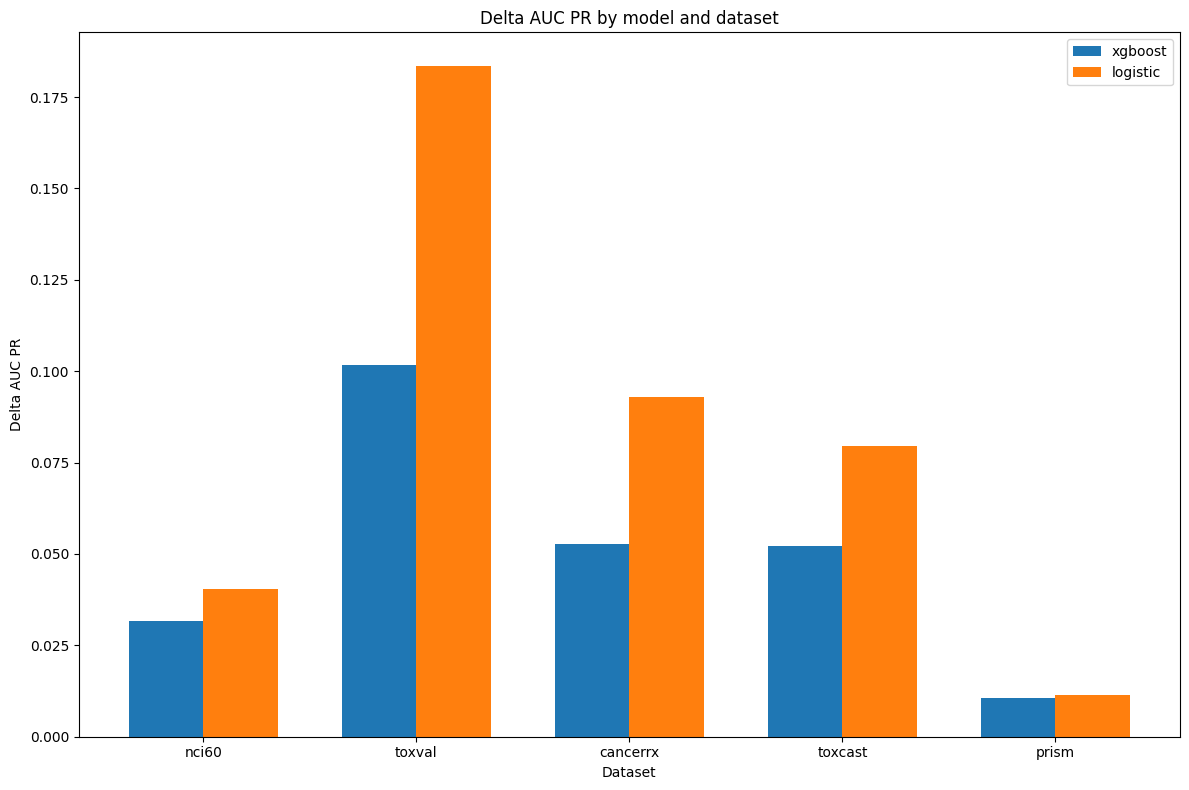

In [16]:
import numpy as np

datasets = df_final["dataset"].unique().tolist()
models = df_final["model"].unique().tolist()
feature_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create an array of dataset indices for plot positioning
dataset_indices = np.arange(len(datasets))

for idx, model in enumerate(models):
    model_data = df_final[df_final["model"] == model]
    median_values = [model_data[model_data["dataset"] == dataset]["delta_auc_pr"].median() for dataset in datasets]
    rects = ax.bar(dataset_indices - feature_width/2 + idx*feature_width, median_values, feature_width, label=model)

ax.set_xlabel('Dataset')
ax.set_ylabel('Delta AUC PR')
ax.set_title('Delta AUC PR by model and dataset')
ax.set_xticks(dataset_indices)
ax.set_xticklabels(datasets)
ax.legend()

plt.tight_layout()
plt.show()